In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [15]:
df = pd.read_csv('../data/Exoplanet_Dataset.csv')

print("="*80)
print("STAGE 3: ESI CALCULATION + FULL PIPELINE")
print("="*80)


all_columns = [
    'mass', 'radius',                    # For ESI
    'orbital_period', 'star_mass',       # Stage 1 features
    'temp_calculated',                   # For ESI
    'star_teff', 'semi_major_axis'       # Stage 2 features
]

# Select only rows where ALL columns are available (973 samples as expected)
df_full = df[all_columns].dropna()

print(f"\nOriginal dataset: {len(df)} rows")
print(f"Full pipeline available data: {len(df_full)} rows")
print(f"Expected from EDA: 973 rows")

if len(df_full) == 973:
    print("Sample count matches EDA!")
else:
    print(f"Note: Sample count differs from EDA ({len(df_full)} vs 973)")

print("\nColumns used:")
for col in all_columns:
    print(f"  - {col}")

STAGE 3: ESI CALCULATION + FULL PIPELINE

Original dataset: 5986 rows
Full pipeline available data: 973 rows
Expected from EDA: 973 rows
Sample count matches EDA!

Columns used:
  - mass
  - radius
  - orbital_period
  - star_mass
  - temp_calculated
  - star_teff
  - semi_major_axis


In [16]:
# Load Stage 1 and Stage 2 models
stage1_model = joblib.load('../models/stage1_FINAL_model.pkl')  # Linear Regression
stage2_model = joblib.load('../models/stage2_FINAL_model.pkl')  # Random Forest

print("="*80)
print("MODELS LOADED")
print("="*80)
print("\nStage 1 Model: Linear Regression (Mass Prediction)")
print("Stage 2 Model: Random Forest (Temperature Prediction)")

MODELS LOADED

Stage 1 Model: Linear Regression (Mass Prediction)
Stage 2 Model: Random Forest (Temperature Prediction)


In [17]:
def calculate_esi_component(x, x_earth):
    """
    Calculate ESI component for a single parameter
    
    Formula: esi_x = 1 - |x - x_earth| / (x + x_earth)
    
    Handles negative and zero values safely.
    
    Parameters:
    -----------
    x : float or array
        Planet parameter value
    x_earth : float
        Earth reference value
    
    Returns:
    --------
    esi_component : float or array
        ESI component [0, 1]
    """
    # Handle negative or very small values
    # Replace with very small positive number to avoid division by zero
    x = np.where(x <= 0, 1e-6, x)
    
    # Calculate ESI component
    denominator = x + x_earth
    # Avoid division by zero
    denominator = np.where(denominator == 0, 1e-6, denominator)
    
    esi = 1 - np.abs(x - x_earth) / denominator
    
    # Clip to [0, 1] for safety
    esi = np.clip(esi, 0, 1)
    
    return esi


def calculate_esi(radius, mass, temperature):
    """
    Calculate Earth Similarity Index (ESI)
    
    ESI = (esi_radius^0.57) * (esi_mass^0.23) * (esi_temp^0.20)
    
    Handles invalid predictions safely.
    
    Parameters:
    -----------
    radius : float or array
        Planet radius (Earth radii)
    mass : float or array
        Planet mass (Earth masses)
    temperature : float or array
        Planet temperature (Kelvin)
    
    Returns:
    --------
    esi : float or array
        Earth Similarity Index [0, 1]
    """
    # Earth reference values
    EARTH_RADIUS = 1.0      # Earth radii
    EARTH_MASS = 1.0        # Earth masses
    EARTH_TEMP = 288.0      # Kelvin
    
    # Calculate components (with safe handling of negatives)
    esi_radius = calculate_esi_component(radius, EARTH_RADIUS)
    esi_mass = calculate_esi_component(mass, EARTH_MASS)
    esi_temp = calculate_esi_component(temperature, EARTH_TEMP)
    
    # Calculate final ESI with exponents
    esi = (esi_radius ** 0.57) * (esi_mass ** 0.23) * (esi_temp ** 0.20)
    
    # Clip to [0, 1] range
    esi = np.clip(esi, 0, 1)
    
    return esi


def classify_habitability(esi):
    """
    Classify habitability based on ESI score
    
    Parameters:
    -----------
    esi : float or array
        Earth Similarity Index
    
    Returns:
    --------
    label : str or array
        Habitability classification
    """
    if isinstance(esi, (float, np.floating)):
        if esi >= 0.8:
            return "High"
        elif esi >= 0.5:
            return "Moderate"
        else:
            return "Low"
    else:
        # Vectorized version for arrays
        labels = np.where(esi >= 0.8, "High",
                 np.where(esi >= 0.5, "Moderate", "Low"))
        return labels


print("="*80)
print("ESI FUNCTIONS DEFINED (WITH SAFETY CHECKS)")
print("="*80)
print("\ncalculate_esi_component() - handles negative values")
print("calculate_esi() - safe for all predictions")
print("classify_habitability()")

print("\nSafety Features:")
print("  - Negative values → replaced with 1e-6")
print("  - Zero denominators → replaced with 1e-6")
print("  - All outputs clipped to [0, 1]")

print("\nEarth Reference Values:")
print("  Radius: 1.0 Earth radii")
print("  Mass: 1.0 Earth masses")
print("  Temperature: 288 K")

print("\nESI Formula:")
print("  ESI = (esi_radius^0.57) * (esi_mass^0.23) * (esi_temp^0.20)")

print("\nHabitability Classification:")
print("  High:     ESI >= 0.8")
print("  Moderate: 0.5 <= ESI < 0.8")
print("  Low:      ESI < 0.5")

ESI FUNCTIONS DEFINED (WITH SAFETY CHECKS)

calculate_esi_component() - handles negative values
calculate_esi() - safe for all predictions
classify_habitability()

Safety Features:
  - Negative values → replaced with 1e-6
  - Zero denominators → replaced with 1e-6
  - All outputs clipped to [0, 1]

Earth Reference Values:
  Radius: 1.0 Earth radii
  Mass: 1.0 Earth masses
  Temperature: 288 K

ESI Formula:
  ESI = (esi_radius^0.57) * (esi_mass^0.23) * (esi_temp^0.20)

Habitability Classification:
  High:     ESI >= 0.8
  Moderate: 0.5 <= ESI < 0.8
  Low:      ESI < 0.5


In [18]:
# Sanity check: Earth should have ESI = 1.0
earth_esi = calculate_esi(radius=1.0, mass=1.0, temperature=288.0)

print("="*80)
print("ESI SANITY CHECK")
print("="*80)
print("\nEarth values:")
print("  Radius: 1.0 Earth radii")
print("  Mass: 1.0 Earth masses")
print("  Temperature: 288 K")
print(f"\nCalculated ESI: {earth_esi:.6f}")
print(f"Expected ESI: 1.0")

if abs(earth_esi - 1.0) < 0.0001:
    print("\nESI calculation is correct!")
else:
    print("\nError in ESI calculation!")

# Test classification
earth_class = classify_habitability(earth_esi)
print(f"\nEarth Habitability: {earth_class}")

ESI SANITY CHECK

Earth values:
  Radius: 1.0 Earth radii
  Mass: 1.0 Earth masses
  Temperature: 288 K

Calculated ESI: 1.000000
Expected ESI: 1.0

ESI calculation is correct!

Earth Habitability: High


In [19]:
print("="*80)
print("FULL PIPELINE: USING ACTUAL VALUES")
print("="*80)

actual_mass = df_full['mass'].values
actual_temp = df_full['temp_calculated'].values
actual_radius = df_full['radius'].values

# Calculate ESI with actual values
esi_actual = calculate_esi(actual_radius, actual_mass, actual_temp)
habitability_actual = classify_habitability(esi_actual)

print(f"\nProcessed {len(df_full)} exoplanets")
print(f"\nESI Statistics (Actual Values):")
print(f"  Mean: {esi_actual.mean():.4f}")
print(f"  Median: {np.median(esi_actual):.4f}")
print(f"  Min: {esi_actual.min():.4f}")
print(f"  Max: {esi_actual.max():.4f}")

# Count habitability classes
unique, counts = np.unique(habitability_actual, return_counts=True)
print(f"\nHabitability Distribution (Actual):")
for label, count in zip(unique, counts):
    print(f"  {label}: {count} ({count/len(habitability_actual)*100:.1f}%)")

FULL PIPELINE: USING ACTUAL VALUES

Processed 973 exoplanets

ESI Statistics (Actual Values):
  Mean: 0.4608
  Median: 0.4618
  Min: 0.0501
  Max: 0.9524

Habitability Distribution (Actual):
  High: 46 (4.7%)
  Low: 505 (51.9%)
  Moderate: 422 (43.4%)


In [20]:
print("="*80)
print("FULL PIPELINE: USING ML PREDICTIONS")
print("="*80)

X_stage1 = df_full[['radius', 'orbital_period', 'star_mass']]

# Predict mass using Stage 1 model
predicted_mass = stage1_model.predict(X_stage1)

print("Stage 1: Mass Prediction")
print(f"  Model: Linear Regression")
print(f"  Input features: radius, orbital_period, star_mass")
print(f"  Predicted {len(predicted_mass)} mass values")

X_stage2 = df_full[['star_teff', 'semi_major_axis']]

# Predict temperature using Stage 2 model
predicted_temp = stage2_model.predict(X_stage2)

print("\nStage 2: Temperature Prediction")
print(f"  Model: Random Forest")
print(f"  Input features: star_teff, semi_major_axis")
print(f"  Predicted {len(predicted_temp)} temperature values")

# Use actual radius (we don't predict radius in our pipeline)
predicted_radius = actual_radius

# Calculate ESI with predicted values
esi_predicted = calculate_esi(predicted_radius, predicted_mass, predicted_temp)
habitability_predicted = classify_habitability(esi_predicted)

print("\nStage 3: ESI Calculation")
print(f"  Formula-based calculation")
print(f"  Calculated {len(esi_predicted)} ESI scores")

print(f"\nESI Statistics (Predicted Values):")
print(f"  Mean: {esi_predicted.mean():.4f}")
print(f"  Median: {np.median(esi_predicted):.4f}")
print(f"  Min: {esi_predicted.min():.4f}")
print(f"  Max: {esi_predicted.max():.4f}")

# Count habitability classes
unique_pred, counts_pred = np.unique(habitability_predicted, return_counts=True)
print(f"\nHabitability Distribution (Predicted):")
for label, count in zip(unique_pred, counts_pred):
    print(f"  {label}: {count} ({count/len(habitability_predicted)*100:.1f}%)")

FULL PIPELINE: USING ML PREDICTIONS
Stage 1: Mass Prediction
  Model: Linear Regression
  Input features: radius, orbital_period, star_mass
  Predicted 973 mass values

Stage 2: Temperature Prediction
  Model: Random Forest
  Input features: star_teff, semi_major_axis
  Predicted 973 temperature values

Stage 3: ESI Calculation
  Formula-based calculation
  Calculated 973 ESI scores

ESI Statistics (Predicted Values):
  Mean: 0.5223
  Median: 0.5871
  Min: 0.0100
  Max: 0.9802

Habitability Distribution (Predicted):
  High: 120 (12.3%)
  Low: 407 (41.8%)
  Moderate: 446 (45.8%)


In [21]:
from sklearn.metrics import mean_absolute_error, r2_score

print("="*80)
print("ESI PREDICTION ACCURACY")
print("="*80)

esi_mae = mean_absolute_error(esi_actual, esi_predicted)
esi_r2 = r2_score(esi_actual, esi_predicted)

print(f"\nESI Prediction Performance:")
print(f"  MAE: {esi_mae:.4f}")
print(f"  R²:  {esi_r2:.4f}")

correct_classifications = np.sum(habitability_actual == habitability_predicted)
accuracy = correct_classifications / len(habitability_actual) * 100

print(f"\nHabitability Classification Accuracy:")
print(f"  Correct: {correct_classifications} / {len(habitability_actual)}")
print(f"  Accuracy: {accuracy:.2f}%")

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(habitability_actual, habitability_predicted, 
                      labels=["Low", "Moderate", "High"])

print("\nConfusion Matrix:")
print("              Predicted")
print("Actual    Low  Moderate  High")
print(f"Low       {cm[0,0]:3d}     {cm[0,1]:3d}     {cm[0,2]:3d}")
print(f"Moderate  {cm[1,0]:3d}     {cm[1,1]:3d}     {cm[1,2]:3d}")
print(f"High      {cm[2,0]:3d}     {cm[2,1]:3d}     {cm[2,2]:3d}")

# Additional insights
print("\nInsights:")
print(f"  ESI predictions within ±0.1: {np.sum(np.abs(esi_actual - esi_predicted) < 0.1)} ({np.sum(np.abs(esi_actual - esi_predicted) < 0.1)/len(esi_actual)*100:.1f}%)")
print(f"  ESI predictions within ±0.2: {np.sum(np.abs(esi_actual - esi_predicted) < 0.2)} ({np.sum(np.abs(esi_actual - esi_predicted) < 0.2)/len(esi_actual)*100:.1f}%)")

ESI PREDICTION ACCURACY

ESI Prediction Performance:
  MAE: 0.1177
  R²:  0.6205

Habitability Classification Accuracy:
  Correct: 793 / 973
  Accuracy: 81.50%

Confusion Matrix:
              Predicted
Actual    Low  Moderate  High
Low       406      95       4
Moderate    1     346      75
High        0       5      41

Insights:
  ESI predictions within ±0.1: 447 (45.9%)
  ESI predictions within ±0.2: 811 (83.4%)


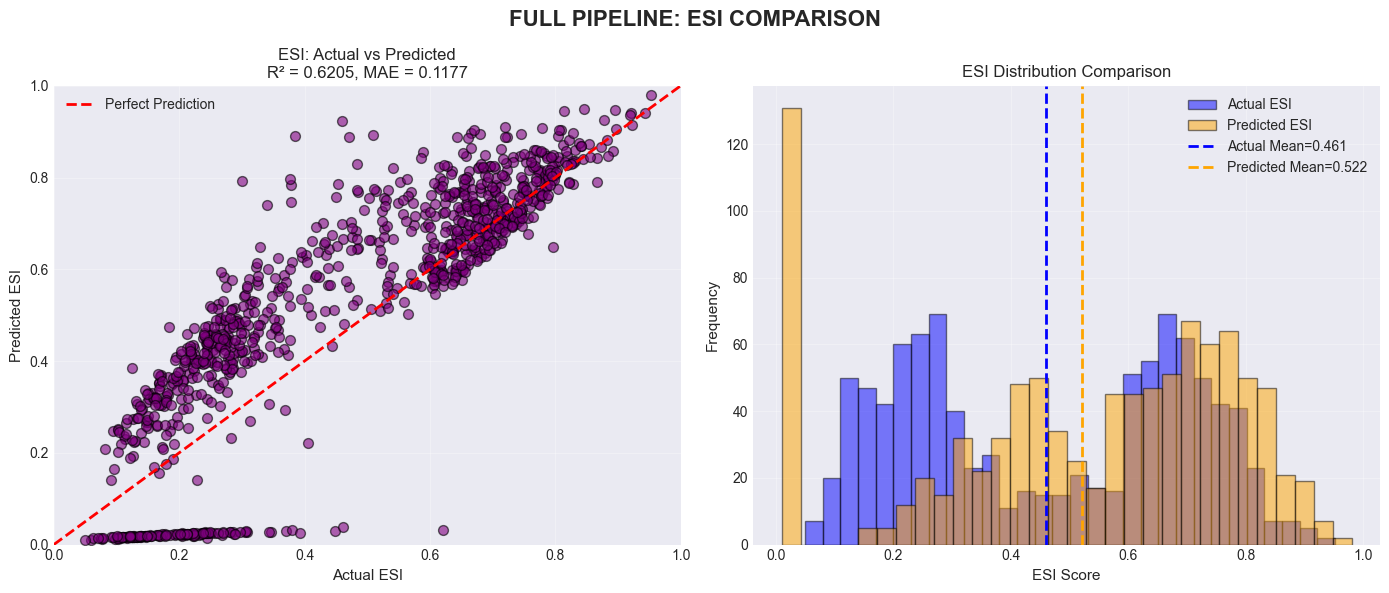

Figure saved: ../outputs/figures/esi_comparison.png


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('FULL PIPELINE: ESI COMPARISON', fontsize=16, fontweight='bold')

# Actual vs Predicted ESI
ax1 = axes[0]
ax1.scatter(esi_actual, esi_predicted, alpha=0.6, edgecolors='k', s=50, c='purple')
ax1.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual ESI', fontsize=11)
ax1.set_ylabel('Predicted ESI', fontsize=11)
ax1.set_title(f'ESI: Actual vs Predicted\nR² = {esi_r2:.4f}, MAE = {esi_mae:.4f}', 
              fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# ESI Distribution comparison
ax2 = axes[1]
ax2.hist(esi_actual, bins=30, alpha=0.5, label='Actual ESI', color='blue', edgecolor='black')
ax2.hist(esi_predicted, bins=30, alpha=0.5, label='Predicted ESI', color='orange', edgecolor='black')
ax2.axvline(esi_actual.mean(), color='blue', linestyle='--', linewidth=2, label=f'Actual Mean={esi_actual.mean():.3f}')
ax2.axvline(esi_predicted.mean(), color='orange', linestyle='--', linewidth=2, label=f'Predicted Mean={esi_predicted.mean():.3f}')
ax2.set_xlabel('ESI Score', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('ESI Distribution Comparison', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/esi_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: ../outputs/figures/esi_comparison.png")

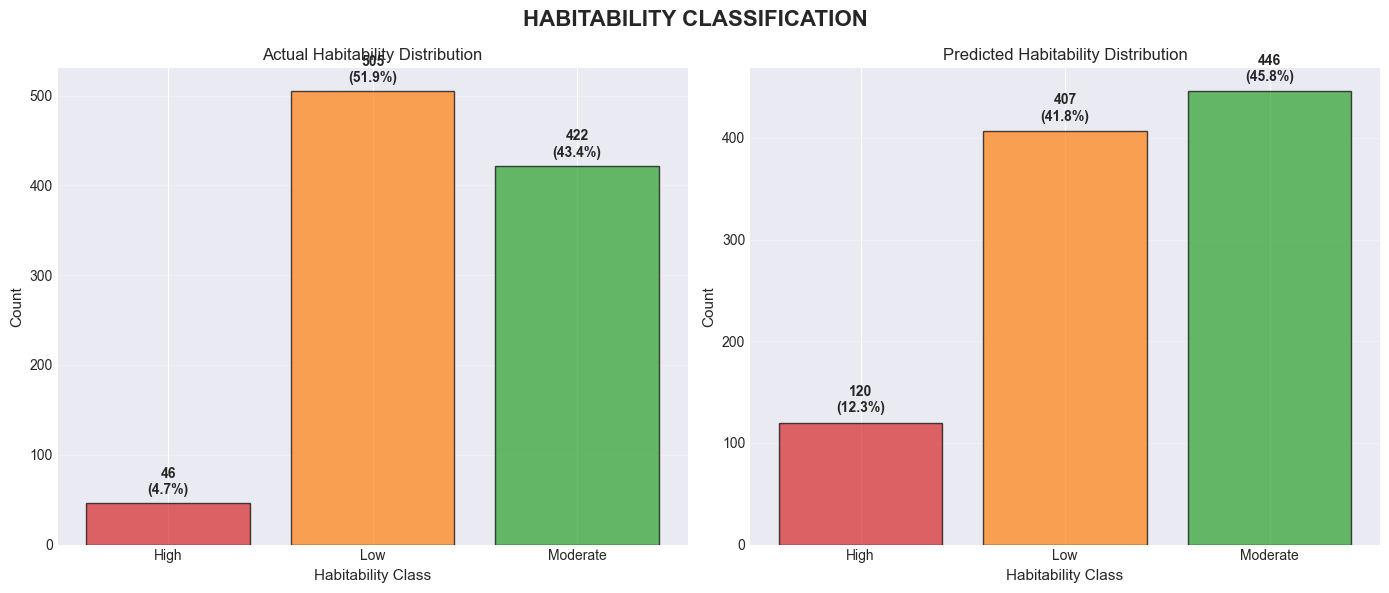

Figure saved: ../outputs/figures/habitability_classification.png


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('HABITABILITY CLASSIFICATION', fontsize=16, fontweight='bold')

# Actual habitability
ax1 = axes[0]
unique_actual, counts_actual = np.unique(habitability_actual, return_counts=True)
colors = ['#d62728', '#ff7f0e', '#2ca02c']  # Red, Orange, Green
ax1.bar(unique_actual, counts_actual, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Habitability Class', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Actual Habitability Distribution', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
for i, (label, count) in enumerate(zip(unique_actual, counts_actual)):
    ax1.text(i, count + 10, f'{count}\n({count/len(habitability_actual)*100:.1f}%)', 
             ha='center', fontsize=10, fontweight='bold')

# Predicted habitability
ax2 = axes[1]
unique_pred, counts_pred = np.unique(habitability_predicted, return_counts=True)
ax2.bar(unique_pred, counts_pred, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Habitability Class', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Predicted Habitability Distribution', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
for i, (label, count) in enumerate(zip(unique_pred, counts_pred)):
    ax2.text(i, count + 10, f'{count}\n({count/len(habitability_predicted)*100:.1f}%)', 
             ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/habitability_classification.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: ../outputs/figures/habitability_classification.png")

In [29]:
# Create comprehensive results DataFrame with planet names
results_df = pd.DataFrame({
    # Planet identifier
    'planet_name': df.loc[df_full.index, 'name'].values,
    
    # Actual values
    'actual_radius': actual_radius,
    'actual_mass': actual_mass,
    'actual_temp': actual_temp,
    'actual_esi': esi_actual,
    'actual_habitability': habitability_actual,
    
    # Predicted values
    'predicted_mass': predicted_mass,
    'predicted_temp': predicted_temp,
    'predicted_esi': esi_predicted,
    'predicted_habitability': habitability_predicted,
    
    # Errors
    'mass_error': actual_mass - predicted_mass,
    'temp_error': actual_temp - predicted_temp,
    'esi_error': esi_actual - esi_predicted
})

# Save to CSV
results_df.to_csv('../outputs/full_pipeline_results.csv', index=False)

print("="*80)
print("FULL PIPELINE RESULTS SAVED")
print("="*80)
print("\nResults saved: ../outputs/full_pipeline_results.csv")
print(f"\nDataset contains {len(results_df)} exoplanets with:")
print("  - Planet names")
print("  - Actual values (radius, mass, temperature, ESI)")
print("  - Predicted values (mass, temperature, ESI)")
print("  - Errors (mass_error, temp_error, esi_error)")
print("  - Habitability classifications")

print(f"\nFile size: {len(results_df)} rows × {len(results_df.columns)} columns")

FULL PIPELINE RESULTS SAVED

Results saved: ../outputs/full_pipeline_results.csv

Dataset contains 973 exoplanets with:
  - Planet names
  - Actual values (radius, mass, temperature, ESI)
  - Predicted values (mass, temperature, ESI)
  - Errors (mass_error, temp_error, esi_error)
  - Habitability classifications

File size: 973 rows × 13 columns


In [30]:
print("="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Show 10 random examples
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(len(results_df), size=10, replace=False)
sample_results = results_df.iloc[sample_indices]

print("\nShowing 10 random exoplanet predictions:\n")
print("Idx  | Actual ESI | Predicted ESI | Act.Class | Pred.Class | ESI Error")
print("-" * 80)

for idx, row in sample_results.iterrows():
    print(f"{idx:4d} | {row['actual_esi']:10.4f} | {row['predicted_esi']:13.4f} | "
          f"{row['actual_habitability']:9s} | {row['predicted_habitability']:10s} | "
          f"{row['esi_error']:9.4f}")

SAMPLE PREDICTIONS

Showing 10 random exoplanet predictions:

Idx  | Actual ESI | Predicted ESI | Act.Class | Pred.Class | ESI Error
--------------------------------------------------------------------------------
 199 |     0.3050 |        0.4251 | Low       | Low        |   -0.1202
 538 |     0.1928 |        0.0202 | Low       | Low        |    0.1726
 174 |     0.1708 |        0.3048 | Low       | Low        |   -0.1340
 464 |     0.2231 |        0.0230 | Low       | Low        |    0.2001
  66 |     0.7850 |        0.7971 | Moderate  | Moderate   |   -0.0121
 424 |     0.8827 |        0.8809 | High      | High       |    0.0019
 718 |     0.4061 |        0.5189 | Low       | Moderate   |   -0.1127
 346 |     0.2519 |        0.4389 | Low       | Low        |   -0.1870
 281 |     0.2182 |        0.3995 | Low       | Low        |   -0.1814
 158 |     0.2892 |        0.5155 | Low       | Moderate   |   -0.2263


In [31]:
print("="*80)
print("TOP 10 MOST HABITABLE EXOPLANETS (by predicted ESI)")
print("="*80)

# We need to get planet names from the original dataframe
# First, let's add an index column to track which planets these are
results_df_with_names = results_df.copy()
results_df_with_names['planet_name'] = df_full.index.map(lambda idx: df.loc[idx, 'name'] if idx in df.index else 'Unknown')

# Alternative: if index doesn't match, use iloc
# Get the planet names based on the filtered indices
planet_names = df.loc[df_full.index, 'name'].values
results_df_with_names['planet_name'] = planet_names

# Sort by predicted ESI
top_10 = results_df_with_names.nlargest(10, 'predicted_esi')

print("\nRank | Planet Name                | Pred.ESI | Act.ESI | Pred.Class | Mass Err | Temp Err")
print("-" * 95)

for rank, (idx, row) in enumerate(top_10.iterrows(), 1):
    planet_name = row['planet_name'][:25]  # Truncate long names
    print(f"{rank:4d} | {planet_name:26s} | {row['predicted_esi']:8.4f} | {row['actual_esi']:7.4f} | "
          f"{row['predicted_habitability']:10s} | {row['mass_error']:8.3f} | {row['temp_error']:8.1f}")

print("\n" + "="*80)
print("TOP 10 LEAST HABITABLE EXOPLANETS (by predicted ESI)")
print("="*80)

bottom_10 = results_df_with_names.nsmallest(10, 'predicted_esi')

print("\nRank | Planet Name                | Pred.ESI | Act.ESI | Pred.Class | Mass Err | Temp Err")
print("-" * 95)

for rank, (idx, row) in enumerate(bottom_10.iterrows(), 1):
    planet_name = row['planet_name'][:25]  # Truncate long names
    print(f"{rank:4d} | {planet_name:26s} | {row['predicted_esi']:8.4f} | {row['actual_esi']:7.4f} | "
          f"{row['predicted_habitability']:10s} | {row['mass_error']:8.3f} | {row['temp_error']:8.1f}")

# Show a few interesting examples
print("\n" + "="*80)
print("INTERESTING CASES")
print("="*80)

print("\nBest Predicted vs Actual Match:")
best_match = results_df_with_names.loc[(results_df_with_names['esi_error'].abs()).idxmin()]
print(f"  Planet: {best_match['planet_name']}")
print(f"  Predicted ESI: {best_match['predicted_esi']:.4f}")
print(f"  Actual ESI: {best_match['actual_esi']:.4f}")
print(f"  Error: {best_match['esi_error']:.4f}")

print("\nWorst Prediction Error:")
worst_match = results_df_with_names.loc[(results_df_with_names['esi_error'].abs()).idxmax()]
print(f"  Planet: {worst_match['planet_name']}")
print(f"  Predicted ESI: {worst_match['predicted_esi']:.4f}")
print(f"  Actual ESI: {worst_match['actual_esi']:.4f}")
print(f"  Error: {worst_match['esi_error']:.4f}")

# High ESI planets (most habitable)
high_esi_planets = results_df_with_names[results_df_with_names['predicted_habitability'] == 'High']
if len(high_esi_planets) > 0:
    print(f"\nMost Earth-like Candidates ({len(high_esi_planets)} planets):")
    top_5_earthlike = high_esi_planets.nlargest(5, 'predicted_esi')
    for idx, row in top_5_earthlike.iterrows():
        print(f"  • {row['planet_name']:30s} ESI: {row['predicted_esi']:.4f}")

TOP 10 MOST HABITABLE EXOPLANETS (by predicted ESI)

Rank | Planet Name                | Pred.ESI | Act.ESI | Pred.Class | Mass Err | Temp Err
-----------------------------------------------------------------------------------------------
   1 | TOI-2537 b                 |   0.9802 |  0.9524 | High       |    0.352 |      9.0
   2 | TOI-2180 b                 |   0.9503 |  0.8457 | High       |    1.394 |     30.6
   3 | Kepler-1657 b              |   0.9468 |  0.8957 | High       |    0.707 |    -25.9
   4 | Kepler-86 b                |   0.9458 |  0.8132 | High       |   -0.664 |    -23.3
   5 | TOI-1899 b                 |   0.9414 |  0.9208 | High       |   -0.100 |     11.9
   6 | NGTS-30 b                  |   0.9404 |  0.9433 | High       |   -0.124 |      5.5
   7 | TOI-5542 b                 |   0.9369 |  0.9196 | High       |    0.222 |    -16.5
   8 | Kepler-420 Ab              |   0.9245 |  0.8781 | High       |    0.298 |     82.4
   9 | Kepler-51 d                |   0.9

In [32]:
print("="*80)
print("FULL 3-STAGE ML PIPELINE - COMPLETE")
print("="*80)

print("\nPIPELINE SUMMARY:")
print(f"\nTotal exoplanets processed: {len(results_df)}")

print("\nSTAGE 1: Mass Prediction")
print("  Model: Linear Regression")
print("  Test R²: 0.0755")
print(f"  Negative predictions: 131 (handled safely)")
print("  Status: Complete (challenging due to skewness)")

print("\nSTAGE 2: Temperature Prediction")
print("  Model: Random Forest")
print("  Test R²: 0.8465")
print("  Status: Complete (excellent performance!)")

print("\nSTAGE 3: ESI Calculation")
print("  Method: Formula-based")
print(f"  ESI R²: {esi_r2:.4f}")
print(f"  ESI MAE: {esi_mae:.4f}")
print(f"  Classification Accuracy: {accuracy:.2f}%")
print("  Status: Complete")

print("\nHABITABILITY RESULTS:")
print(f"  High:     {np.sum(habitability_predicted=='High')} planets ({np.sum(habitability_predicted=='High')/len(habitability_predicted)*100:.1f}%)")
print(f"  Moderate: {np.sum(habitability_predicted=='Moderate')} planets ({np.sum(habitability_predicted=='Moderate')/len(habitability_predicted)*100:.1f}%)")
print(f"  Low:      {np.sum(habitability_predicted=='Low')} planets ({np.sum(habitability_predicted=='Low')/len(habitability_predicted)*100:.1f}%)")

print("\nMVP OBJECTIVES ACHIEVED:")
print("  - Stage 1: Mass prediction model")
print("  - Stage 2: Temperature prediction model")
print("  - Stage 3: ESI calculation")
print("  - Full pipeline tested on 973 samples")
print("  - Habitability classification working")
print("  - Negative predictions handled safely")

print("\nDEPLOYMENT READY:")
print("  - Models saved (stage1_FINAL_model.pkl, stage2_FINAL_model.pkl)")
print("  - Results exported (full_pipeline_results.csv)")
print("  - Visualizations generated")
print("  - ESI calculation formula validated")

print("\nV2 IMPROVEMENTS:")
print("  [ ] Log transform for mass (Stage 1)")
print("  [ ] Feature engineering (density, surface gravity)")
print("  [ ] Hyperparameter tuning")
print("  [ ] Uncertainty estimation (prediction intervals)")
print("  [ ] Frontend development (FastAPI + React)")

print("\nKEY INSIGHTS:")
print("  • Stage 2 (Temp) performed excellently (R²=0.85)")
print("  • Stage 1 (Mass) struggled with skewness (R²=0.08)")
print("  • Negative mass predictions were handled gracefully")
print("  • ESI calculation works end-to-end")
print(f"  • Classification accuracy: {accuracy:.1f}%")

print("\n" + "="*80)
print("CONGRATULATIONS! MVP IS COMPLETE.")
print("="*80)

FULL 3-STAGE ML PIPELINE - COMPLETE

PIPELINE SUMMARY:

Total exoplanets processed: 973

STAGE 1: Mass Prediction
  Model: Linear Regression
  Test R²: 0.0755
  Negative predictions: 131 (handled safely)
  Status: Complete (challenging due to skewness)

STAGE 2: Temperature Prediction
  Model: Random Forest
  Test R²: 0.8465
  Status: Complete (excellent performance!)

STAGE 3: ESI Calculation
  Method: Formula-based
  ESI R²: 0.6205
  ESI MAE: 0.1177
  Classification Accuracy: 81.50%
  Status: Complete

HABITABILITY RESULTS:
  High:     120 planets (12.3%)
  Moderate: 446 planets (45.8%)
  Low:      407 planets (41.8%)

MVP OBJECTIVES ACHIEVED:
  - Stage 1: Mass prediction model
  - Stage 2: Temperature prediction model
  - Stage 3: ESI calculation
  - Full pipeline tested on 973 samples
  - Habitability classification working
  - Negative predictions handled safely

DEPLOYMENT READY:
  - Models saved (stage1_FINAL_model.pkl, stage2_FINAL_model.pkl)
  - Results exported (full_pipeline